<a href="https://colab.research.google.com/github/AksharSolanki2697/capstone-project/blob/main/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import collections
import math
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import warnings

import pickle
import time

import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.cluster import KMeans
from wordcloud import WordCloud 

import logging

from scipy.sparse import hstack

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

In [2]:
# Setting a random seed in order to keep the same random results each time I run the notebook
np.random.seed(seed=35)

In [3]:
# Mounting the drive to get the data directly from Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Check access to the data folder
import os 
print(os.listdir("drive/MyDrive/Colab Notebooks/data"))

['Answers.csv', 'Questions.csv', 'Tags.csv', 'preprocessed_data.csv']


### 1.1 Importing Data

In [5]:
# Reading Questions.csv and Tags.csv files into Pandas DataFrame.
questions = pd.read_csv("drive/MyDrive/Colab Notebooks/data/Questions.csv", encoding="ISO-8859-1")
tags = pd.read_csv("drive/MyDrive/Colab Notebooks/data/Tags.csv", encoding="ISO-8859-1")
answers = pd.read_csv("drive/MyDrive/Colab Notebooks/data/Answers.csv", encoding="ISO-8859-1")
tags_copy = tags.copy(deep=True)
questions_copy = questions.copy(deep=True)
answers_copy = answers.copy(deep=True)
# Keeping copies in case need to restore the original data 

In [6]:
# Analyzing the questions data
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [7]:
# Analyzing the tags info
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


In [8]:
#  Analyzing the answers info
answers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2014516 entries, 0 to 2014515
Data columns (total 6 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Id            int64  
 1   OwnerUserId   float64
 2   CreationDate  object 
 3   ParentId      int64  
 4   Score         int64  
 5   Body          object 
dtypes: float64(1), int64(3), object(2)
memory usage: 92.2+ MB


In [9]:
questions.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [10]:
answers.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
1,124,26.0,2008-08-01T16:09:47Z,80,12,<p>I wound up using this. It is a kind of a ha...
2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...
3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur..."
4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article..."


On initial inspection of first 5 rows, we can derive the following analyses of the questions and answers data

1. There are NaN type in `ClosedDate` attribute which indicates that it is Not a Number. 
2. The `Body` attribute has HTML tags like `<p>`, `<strong>` etc.
3. The `Title` attribute has a mix of lower and upper case text.  

In [11]:
tags.head()
# No such analyses can be done for the tags dataframe. 

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [12]:
# Changing the dtype for Tag attribute in tags dataframe
tags['Tag'] = tags['Tag'].astype(str)

In [13]:
# Incase need to restore the data
# tags = tags_copy.copy(deep=True)
# questions = questions_copy.copy(deep=True)


In [ ]:
questions

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...
...,...,...,...,...,...,...,...
1264211,40143210,5610777.0,2016-10-19T23:38:01Z,NaN,0,URL routing in PHP (MVC),<p>I am building a custom MVC project and I ha...
1264212,40143300,3791161.0,2016-10-19T23:48:09Z,NaN,0,Bigquery.Jobs.Insert - Resumable Upload?,<p>The API docs show that you should be able t...
1264213,40143340,7028647.0,2016-10-19T23:52:50Z,NaN,1,Obfuscating code in android studio,<p>Under minifyEnabled I changed from false to...
1264214,40143360,871677.0,2016-10-19T23:55:24Z,NaN,0,How to fire function after v-model change?,<p>I have input which I use to filter my array...


### 1.2 Merging Datasets

In [14]:
def merge_questions_with_tags(questions,tags):
  grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))
  grouped_tags.reset_index()
  grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})
  questions = questions.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'])
  questions = questions.merge(grouped_tags_final, on='Id')
  return questions

questions_merged = merge_questions_with_tags(questions, tags)

In [15]:
questions_merged

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction
...,...,...,...,...,...
1264211,40143210,0,URL routing in PHP (MVC),<p>I am building a custom MVC project and I ha...,php .htaccess
1264212,40143300,0,Bigquery.Jobs.Insert - Resumable Upload?,<p>The API docs show that you should be able t...,google-bigquery
1264213,40143340,1,Obfuscating code in android studio,<p>Under minifyEnabled I changed from false to...,android android-studio
1264214,40143360,0,How to fire function after v-model change?,<p>I have input which I use to filter my array...,javascript vue.js


In [ ]:
questions_merged.isnull().sum()
# The data provided is very clean since there are NO Null Values.

Id       0
Score    0
Title    0
Body     0
Tags     0
dtype: int64

In [ ]:
questions_merged.duplicated().sum()
# No Duplications in the data. 

0

## 1.3 Data Cleaning

### 1.3.1 Cleaning attributes of questions

In [ ]:
questions_merged.drop(columns=['Id', 'Score'], inplace=True)

In [ ]:
questions_merged['Tags'] = questions_merged['Tags'].apply(lambda x: x.split())


In [ ]:
questions_merged

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]"
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]"
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s..."
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]"
...,...,...,...
1264211,URL routing in PHP (MVC),<p>I am building a custom MVC project and I ha...,"[php, .htaccess]"
1264212,Bigquery.Jobs.Insert - Resumable Upload?,<p>The API docs show that you should be able t...,[google-bigquery]
1264213,Obfuscating code in android studio,<p>Under minifyEnabled I changed from false to...,"[android, android-studio]"
1264214,How to fire function after v-model change?,<p>I have input which I use to filter my array...,"[javascript, vue.js]"


In [ ]:
questions_merged['Body'].iloc[0]

'<p>I\'ve written a database generation script in <a href="http://en.wikipedia.org/wiki/SQL">SQL</a> and want to execute it in my <a href="http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime">Adobe AIR</a> application:</p>\n\n<pre><code>Create Table tRole (\n      roleID integer Primary Key\n      ,roleName varchar(40)\n);\nCreate Table tFile (\n    fileID integer Primary Key\n    ,fileName varchar(50)\n    ,fileDescription varchar(500)\n    ,thumbnailID integer\n    ,fileFormatID integer\n    ,categoryID integer\n    ,isFavorite boolean\n    ,dateAdded date\n    ,globalAccessCount integer\n    ,lastAccessTime date\n    ,downloadComplete boolean\n    ,isNew boolean\n    ,isSpotlight boolean\n    ,duration varchar(30)\n);\nCreate Table tCategory (\n    categoryID integer Primary Key\n    ,categoryName varchar(50)\n    ,parent_categoryID integer\n);\n...\n</code></pre>\n\n<p>I execute this in Adobe AIR using the following methods:</p>\n\n<pre><code>public static function RunSqlFromFile

In [ ]:
# Data Cleaning required: 

# Removing html format✔
# Lowering text✔
# Transforming abbreviations
# Removing punctuation (but keeping words like c# since it's the most popular tag)
# Lemmatizing words
# Removing stop words



In [ ]:
questions_merged['Body'] = questions_merged['Body'].apply(lambda x: BeautifulSoup(x).get_text()) 

In [ ]:
questions_merged['Body'] = questions_merged['Body'].str.lower()

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [ ]:
questions_merged['Body'] = questions_merged['Body'].apply(lambda x: clean_text(x)) 

In [ ]:
questions_merged.to_csv('drive/MyDrive/Colab Notebooks/data/preprocessed_data.csv')

### 1.3.2 Cleaning attributes of tags

In [ ]:
all_tags = [item for sublist in questions_merged['Tags'].values for item in sublist]
print("Total number of tags found: " , len(all_tags))
unique_tags = set(all_tags)
print("Unique tags found after converting to set: ", len(unique_tags))

Total number of tags found:  3750994
Unique tags found after converting to set:  37035


In [ ]:
def most_common_tags_and_keywords(questions):
  tags_list = [tag for tags in questions['Tags'].values for tag in tags]
  keywords = nltk.FreqDist(tags_list)
  keywords = nltk.FreqDist(keywords)
  frequencies_words = keywords.most_common(370)
  tags_features = [word[0] for word in frequencies_words]
  return (tags_features,keywords)
(tags_features, keywords) = most_common_tags_and_keywords(questions_merged)

In [ ]:
def keep_most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

questions_merged['Tags'] = questions_merged['Tags'].apply(lambda x: keep_most_common(x))
questions_merged['Tags'] = questions_merged['Tags'].apply(lambda x: x if len(x)>0 else None)

In [ ]:
questions_merged.shape

(1264216, 3)

In [ ]:
questions_merged.dropna(subset=['Tags'], inplace=True)
# Keeping questions with only 370 tags

In [ ]:
questions_merged

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,i've written a database generation script in s...,"[flex, actionscript-3]"
1,Good branching and merging tutorials for Torto...,are there any really good tutorials explaining...,[svn]
2,ASP.NET Site Maps,has anyone got experience creating sql-based a...,"[sql, asp.net]"
3,Function for creating color wheels,this is something i've pseudo-solved many time...,[algorithm]
4,Adding scripting functionality to .NET applica...,i have a little game written in c#. it uses a ...,"[c#, .net]"
...,...,...,...
1264209,How to bind a model to resource store method i...,i am trying to assign a product model for stor...,[laravel]
1264210,How to execute multiline python code from a ba...,i need to extend a shell script (bash). as i a...,"[python, bash]"
1264211,URL routing in PHP (MVC),i am building a custom mvc project and i have ...,"[php, .htaccess]"
1264213,Obfuscating code in android studio,under minifyenabled i changed from false to tr...,"[android, android-studio]"


## 1.4 Visualizations

In [ ]:
# wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(questions_merged['Title'].tolist()))
# plt.figure( figsize=(20,10), facecolor='k')
# plt.imshow(wordcloud)
# plt.title('Most common words in the Title')

In [16]:
ans_per_question = collections.Counter(answers['ParentId'])
answerid,noAnswers= zip(*ans_per_question.most_common())
text = "Avegrage number of answers per question ",np.mean(noAnswers)

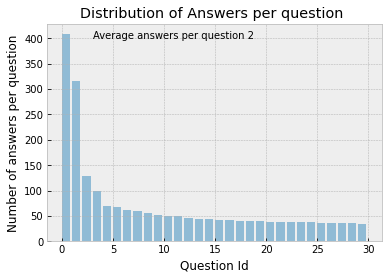

In [17]:
N=30
plt.bar(range(N), noAnswers[:N], align='edge', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('Number of answers per question')
plt.xlabel('Question Id')
plt.title('Distribution of Answers per question ')
plt.text(3,400,"Average answers per question "+str(math.ceil((np.mean(noAnswers)))))
plt.show()

In [18]:
tags

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn
...,...,...
3750989,40143360,javascript
3750990,40143360,vue.js
3750991,40143380,npm
3750992,40143380,mocha


[('javascript', 124155), ('java', 115212), ('c#', 101186), ('php', 98808), ('android', 90659), ('jquery', 78542), ('python', 64601), ('html', 58976), ('c++', 47591), ('ios', 47009)]


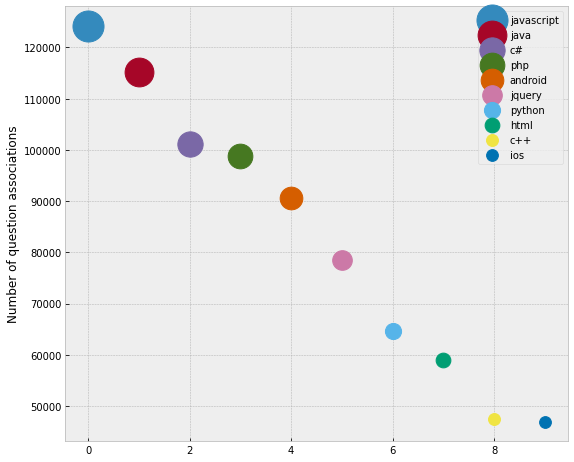

In [20]:
def plot_tags(tagCount):
    
    x,y = zip(*tagCount)

    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colors = [colormap(i) for i in np.linspace(0, 0.8,50)]   

    area = [i/4000 for i in list(y)]   # 0 to 15 point radiuses
    plt.figure(figsize=(9,8))
    plt.ylabel("Number of question associations")
    for i in range(len(y)):
        plt.plot(i,y[i], marker='o', linestyle='',ms=area[i],label=x[i])

    plt.legend(numpoints=1)
    plt.show()

tagCount =  collections.Counter(list(tags['Tag'])).most_common(10)
print(tagCount)
plot_tags(tagCount)

Text(0.5, 1.0, 'Most common Tags')

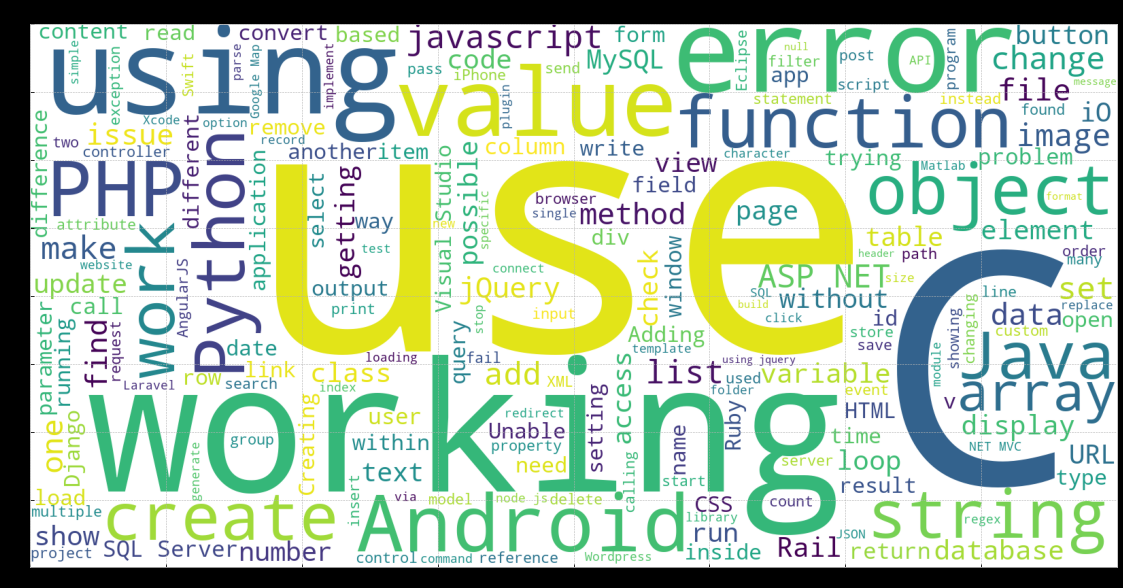

In [ ]:
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(questions_merged['Title'].tolist()))
plt.figure( figsize=(20,10), facecolor='k')  
plt.imshow(wordcloud)
plt.title('Most common Tags')

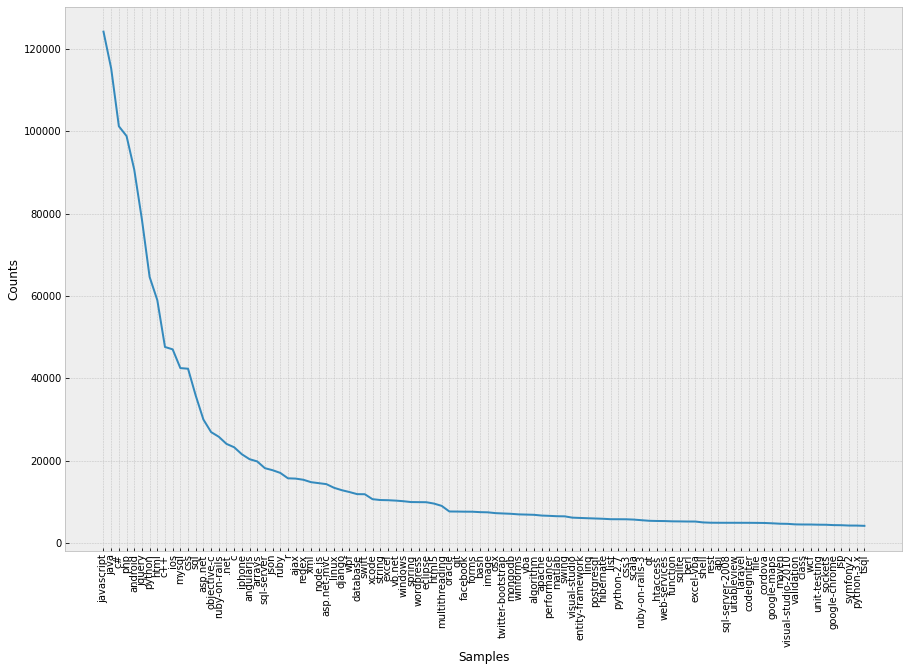

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
keywords.plot(100, cumulative=False)